### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-06 06:45:56--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.2’

onegin.txt.2        100%[===================>] 256.37K  --.-KB/s    in 0.1s    

2024-11-06 06:45:56 (1.68 MB/s) - ‘onegin.txt.2’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________    

Пример батча:

In [6]:
next(generate_chunk())

array([[83,  1, 47, ..., 64, 50, 63],
       [83,  1, 46, ..., 47, 53, 50],
       [83, 63, 62, ...,  1, 62, 63],
       ...,
       [83,  1, 47, ..., 69, 73,  1],
       [83, 56, 53, ..., 61, 45, 62],
       [83, 62, 47, ..., 40, 40, 26]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [7]:
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, device=device):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.device = device
        
        self.encoder = nn.Embedding(input_size, hidden_size)
#         self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.15)
        self.decoder = nn.Linear(hidden_size, output_size)
        
#     def forward(self, input_seq, hidden):
    def forward(self, input_seq, h0, c0):
#         print("---")
#         print(input_seq.shape)
        emb = self.encoder(input_seq)
#         print(emb.shape)
        
#         output, hidden = self.gru(emb, hidden)
        output, (h0, c0) = self.lstm(emb, (h0, c0))
#         print(output.shape)
#         print(hidden.shape)
        output = self.dropout(output)
        output = self.decoder(output)
#         print(output.shape)
        
#         return output, hidden
        return output, (h0, c0)

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, self.hidden_size)).to(device)

In [8]:
def train(model, inp, criterion, optim):
    model.train()
    hidden = model.init_hidden().to(device)
    model.zero_grad()
    loss = 0
    hidden = (hidden, hidden)
    for c in range(seq_length - 1):
        output, hidden = model(inp[:, c], *hidden)
        loss += criterion(output, inp[:, c + 1])

    loss.backward()
    optim.step()

    return loss.item() / seq_length

In [9]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [174]:
# def evaluate(model, prime_str='д', predict_len=100, temperature=0.8):
#     hidden = model.init_hidden()
#     prime_input = char_tensor(prime_str)
#     predicted = prime_str

#     # Use priming string to "build up" hidden state
#     for p in range(len(prime_str) - 1):
#         _, hidden = decoder(prime_input[p], hidden)
#     inp = prime_input[-1]
    
#     for p in range(predict_len):
#         output, hidden = decoder(inp, hidden)
        
#         # Sample from the network as a multinomial distribution
#         output_dist = output.data.view(-1).div(temperature).exp()
#         top_i = torch.multinomial(output_dist, 1)[0]
        
#         # Add predicted character to string and use as next input
#         predicted_char = all_characters[top_i]
#         predicted += predicted_char
#         inp = char_tensor(predicted_char)

#     return predicted

In [10]:
from tqdm import tqdm
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1

# batch_size = 128

model = RNN(num_tokens, hidden_size, num_tokens, n_layers).cuda()
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = [5]
loss_avg = 0

In [26]:
lr = 0.005
optim = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(optim, factor=0.5, patience=500, min_lr=1e-6, cooldown=500)

n_epochs = 12000
for epoch in tqdm(range(1, n_epochs + 1)):
    inp = torch.tensor(next(generate_chunk()), dtype=torch.long).to(device)
    loss = train(model, inp, criterion, optim )       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, lr_scheduler._last_lr[-1]))
#         print(evaluate('Wh', 100), '\n')
    lr_scheduler.step(all_losses[-1])
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

  1%|▋                                                                              | 101/12000 [00:17<34:20,  5.78it/s]

 46s (100 0%) 2.3450 0.0050]


  2%|█▎                                                                             | 201/12000 [00:34<33:05,  5.94it/s]

 3s (200 1%) 2.2405 0.0050]


  3%|█▉                                                                             | 301/12000 [00:51<31:45,  6.14it/s]

 20s (300 2%) 2.2534 0.0050]


  3%|██▋                                                                            | 401/12000 [01:08<33:09,  5.83it/s]

 38s (400 3%) 2.3026 0.0050]


  4%|███▎                                                                           | 501/12000 [01:25<32:47,  5.84it/s]

 55s (500 4%) 2.2515 0.0050]


  5%|███▉                                                                           | 601/12000 [01:43<34:29,  5.51it/s]

 12s (600 5%) 2.3711 0.0025]


  6%|████▌                                                                          | 701/12000 [02:00<31:45,  5.93it/s]

 30s (700 5%) 2.2692 0.0025]


  7%|█████▎                                                                         | 801/12000 [02:17<35:04,  5.32it/s]

 47s (800 6%) 2.2552 0.0025]


  8%|█████▉                                                                         | 901/12000 [02:34<31:54,  5.80it/s]

 4s (900 7%) 2.2013 0.0025]


  8%|██████▌                                                                       | 1001/12000 [02:51<30:22,  6.03it/s]

 21s (1000 8%) 2.2426 0.0025]


  9%|███████▏                                                                      | 1101/12000 [03:08<30:29,  5.96it/s]

 38s (1100 9%) 2.2565 0.0025]


 10%|███████▊                                                                      | 1201/12000 [03:26<30:01,  5.99it/s]

 55s (1200 10%) 2.2110 0.0025]


 11%|████████▍                                                                     | 1301/12000 [03:43<32:33,  5.48it/s]

 12s (1300 10%) 2.3039 0.0025]


 12%|█████████                                                                     | 1401/12000 [04:00<29:38,  5.96it/s]

 29s (1400 11%) 2.2905 0.0025]


 13%|█████████▊                                                                    | 1501/12000 [04:17<31:32,  5.55it/s]

 47s (1500 12%) 2.4032 0.0025]


 13%|██████████▍                                                                   | 1601/12000 [04:34<29:07,  5.95it/s]

 4s (1600 13%) 2.2320 0.0013]


 14%|███████████                                                                   | 1701/12000 [04:51<31:16,  5.49it/s]

 21s (1700 14%) 2.1950 0.0013]


 15%|███████████▋                                                                  | 1801/12000 [05:08<28:33,  5.95it/s]

 38s (1800 15%) 2.4399 0.0013]


 16%|████████████▎                                                                 | 1901/12000 [05:25<28:28,  5.91it/s]

 55s (1900 15%) 2.2074 0.0013]


 17%|█████████████                                                                 | 2001/12000 [05:42<30:45,  5.42it/s]

 12s (2000 16%) 2.2181 0.0013]


 18%|█████████████▋                                                                | 2101/12000 [05:59<28:19,  5.82it/s]

 29s (2100 17%) 2.2184 0.0013]


 18%|██████████████▎                                                               | 2201/12000 [06:17<27:51,  5.86it/s]

 46s (2200 18%) 2.1969 0.0013]


 19%|██████████████▉                                                               | 2301/12000 [06:34<26:27,  6.11it/s]

 3s (2300 19%) 2.2299 0.0013]


 20%|███████████████▌                                                              | 2401/12000 [06:51<26:12,  6.10it/s]

 21s (2400 20%) 2.2322 0.0013]


 21%|████████████████▎                                                             | 2501/12000 [07:08<27:35,  5.74it/s]

 37s (2500 20%) 2.2146 0.0013]


 22%|████████████████▉                                                             | 2601/12000 [07:25<26:03,  6.01it/s]

 55s (2600 21%) 2.2214 0.0013]


 23%|█████████████████▌                                                            | 2701/12000 [07:42<26:44,  5.79it/s]

 12s (2700 22%) 2.3217 0.0006]


 23%|██████████████████▏                                                           | 2801/12000 [07:59<25:46,  5.95it/s]

 29s (2800 23%) 2.3124 0.0006]


 24%|██████████████████▊                                                           | 2901/12000 [08:16<27:15,  5.56it/s]

 46s (2900 24%) 2.2141 0.0006]


 25%|███████████████████▌                                                          | 3001/12000 [08:33<25:20,  5.92it/s]

 3s (3000 25%) 2.1718 0.0006]


 26%|████████████████████▏                                                         | 3101/12000 [08:50<24:36,  6.03it/s]

 20s (3100 25%) 2.2221 0.0006]


 27%|████████████████████▊                                                         | 3201/12000 [09:07<25:28,  5.76it/s]

 37s (3200 26%) 2.2457 0.0006]


 28%|█████████████████████▍                                                        | 3301/12000 [09:24<25:07,  5.77it/s]

 54s (3300 27%) 2.4249 0.0006]


 28%|██████████████████████                                                        | 3401/12000 [09:41<23:43,  6.04it/s]

 11s (3400 28%) 2.2259 0.0006]


 29%|██████████████████████▊                                                       | 3501/12000 [09:59<24:02,  5.89it/s]

 28s (3500 29%) 2.2210 0.0006]


 30%|███████████████████████▍                                                      | 3601/12000 [10:16<25:05,  5.58it/s]

 46s (3600 30%) 2.1823 0.0006]


 31%|████████████████████████                                                      | 3701/12000 [10:33<23:47,  5.81it/s]

 3s (3700 30%) 2.2278 0.0003]


 32%|████████████████████████▋                                                     | 3801/12000 [10:50<22:55,  5.96it/s]

 20s (3800 31%) 2.3225 0.0003]


 33%|█████████████████████████▎                                                    | 3901/12000 [11:07<22:20,  6.04it/s]

 37s (3900 32%) 2.1753 0.0003]


 33%|██████████████████████████                                                    | 4001/12000 [11:24<22:36,  5.90it/s]

 54s (4000 33%) 2.1657 0.0003]


 34%|██████████████████████████▋                                                   | 4101/12000 [11:41<21:58,  5.99it/s]

 11s (4100 34%) 2.1933 0.0003]


 35%|███████████████████████████▎                                                  | 4201/12000 [11:58<21:27,  6.06it/s]

 28s (4200 35%) 2.2221 0.0003]


 36%|███████████████████████████▉                                                  | 4301/12000 [12:15<23:03,  5.56it/s]

 45s (4300 35%) 2.2223 0.0003]


 37%|████████████████████████████▌                                                 | 4401/12000 [12:32<22:03,  5.74it/s]

 2s (4400 36%) 2.2004 0.0003]


 38%|█████████████████████████████▎                                                | 4501/12000 [12:49<22:17,  5.60it/s]

 19s (4500 37%) 2.3923 0.0003]


 38%|█████████████████████████████▉                                                | 4601/12000 [13:07<21:17,  5.79it/s]

 36s (4600 38%) 2.2700 0.0003]


 39%|██████████████████████████████▌                                               | 4701/12000 [13:24<20:26,  5.95it/s]

 54s (4700 39%) 2.2040 0.0003]


 40%|███████████████████████████████▏                                              | 4801/12000 [13:42<19:55,  6.02it/s]

 11s (4800 40%) 2.1652 0.0003]


 41%|███████████████████████████████▊                                              | 4901/12000 [13:59<20:50,  5.68it/s]

 29s (4900 40%) 2.1498 0.0003]


 42%|████████████████████████████████▌                                             | 5001/12000 [14:17<20:54,  5.58it/s]

 46s (5000 41%) 2.2863 0.0003]


 43%|█████████████████████████████████▏                                            | 5101/12000 [14:34<20:09,  5.70it/s]

 4s (5100 42%) 2.1577 0.0003]


 43%|█████████████████████████████████▊                                            | 5201/12000 [14:51<18:22,  6.17it/s]

 21s (5200 43%) 2.3220 0.0002]


 44%|██████████████████████████████████▍                                           | 5301/12000 [15:07<18:11,  6.14it/s]

 37s (5300 44%) 2.1752 0.0002]


 45%|███████████████████████████████████                                           | 5401/12000 [15:24<17:52,  6.15it/s]

 53s (5400 45%) 2.1795 0.0002]


 46%|███████████████████████████████████▊                                          | 5501/12000 [15:40<17:13,  6.29it/s]

 10s (5500 45%) 2.1444 0.0002]


 47%|████████████████████████████████████▍                                         | 5601/12000 [15:56<17:30,  6.09it/s]

 26s (5600 46%) 2.1498 0.0002]


 48%|█████████████████████████████████████                                         | 5701/12000 [16:13<17:22,  6.04it/s]

 42s (5700 47%) 2.2220 0.0002]


 48%|█████████████████████████████████████▋                                        | 5801/12000 [16:29<16:23,  6.30it/s]

 59s (5800 48%) 2.1977 0.0002]


 49%|██████████████████████████████████████▎                                       | 5901/12000 [16:45<16:49,  6.04it/s]

 15s (5900 49%) 2.1859 0.0002]


 50%|███████████████████████████████████████                                       | 6001/12000 [17:02<17:15,  5.79it/s]

 31s (6000 50%) 2.1528 0.0002]


 51%|███████████████████████████████████████▋                                      | 6101/12000 [17:18<15:53,  6.19it/s]

 48s (6100 50%) 2.1755 0.0002]


 52%|████████████████████████████████████████▎                                     | 6201/12000 [17:34<15:31,  6.22it/s]

 4s (6200 51%) 2.1897 0.0001]


 53%|████████████████████████████████████████▉                                     | 6301/12000 [17:51<15:23,  6.17it/s]

 21s (6300 52%) 2.1864 0.0001]


 53%|█████████████████████████████████████████▌                                    | 6401/12000 [18:07<15:41,  5.95it/s]

 37s (6400 53%) 2.1734 0.0001]


 54%|██████████████████████████████████████████▎                                   | 6501/12000 [18:24<14:56,  6.13it/s]

 53s (6500 54%) 2.1998 0.0001]


 55%|██████████████████████████████████████████▉                                   | 6601/12000 [18:40<14:26,  6.23it/s]

 10s (6600 55%) 2.2055 0.0001]


 56%|███████████████████████████████████████████▌                                  | 6701/12000 [18:56<14:36,  6.04it/s]

 26s (6700 55%) 2.1748 0.0001]


 57%|████████████████████████████████████████████▏                                 | 6801/12000 [19:13<14:12,  6.10it/s]

 42s (6800 56%) 2.2053 0.0001]


 58%|████████████████████████████████████████████▊                                 | 6901/12000 [19:29<13:42,  6.20it/s]

 59s (6900 57%) 2.1697 0.0001]


 58%|█████████████████████████████████████████████▌                                | 7001/12000 [19:46<13:30,  6.17it/s]

 16s (7000 58%) 2.1908 0.0001]


 59%|██████████████████████████████████████████████▏                               | 7101/12000 [20:03<14:05,  5.80it/s]

 33s (7100 59%) 2.1653 0.0001]


 60%|██████████████████████████████████████████████▊                               | 7201/12000 [20:20<13:27,  5.94it/s]

 49s (7200 60%) 2.1863 0.0000]


 61%|███████████████████████████████████████████████▍                              | 7301/12000 [20:37<14:06,  5.55it/s]

 7s (7300 60%) 2.1589 0.0000]


 62%|████████████████████████████████████████████████                              | 7401/12000 [20:55<13:13,  5.80it/s]

 25s (7400 61%) 2.1508 0.0000]


 63%|████████████████████████████████████████████████▊                             | 7501/12000 [21:13<14:00,  5.36it/s]

 43s (7500 62%) 2.1530 0.0000]


 63%|█████████████████████████████████████████████████▍                            | 7601/12000 [21:31<13:33,  5.41it/s]

 1s (7600 63%) 2.1848 0.0000]


 64%|██████████████████████████████████████████████████                            | 7701/12000 [21:49<12:23,  5.78it/s]

 19s (7700 64%) 2.1925 0.0000]


 65%|██████████████████████████████████████████████████▋                           | 7801/12000 [22:07<12:48,  5.47it/s]

 37s (7800 65%) 2.1965 0.0000]


 66%|███████████████████████████████████████████████████▎                          | 7901/12000 [22:25<12:26,  5.49it/s]

 55s (7900 65%) 2.3597 0.0000]


 67%|████████████████████████████████████████████████████                          | 8001/12000 [22:43<12:23,  5.38it/s]

 13s (8000 66%) 2.2008 0.0000]


 68%|████████████████████████████████████████████████████▋                         | 8101/12000 [23:01<11:38,  5.58it/s]

 31s (8100 67%) 2.1899 0.0000]


 68%|█████████████████████████████████████████████████████▎                        | 8201/12000 [23:19<10:45,  5.89it/s]

 49s (8200 68%) 2.2329 0.0000]


 69%|█████████████████████████████████████████████████████▉                        | 8301/12000 [23:37<11:25,  5.39it/s]

 7s (8300 69%) 2.1537 0.0000]


 70%|██████████████████████████████████████████████████████▌                       | 8401/12000 [23:55<10:41,  5.61it/s]

 25s (8400 70%) 2.2545 0.0000]


 71%|███████████████████████████████████████████████████████▎                      | 8501/12000 [24:13<10:53,  5.35it/s]

 42s (8500 70%) 2.2785 0.0000]


 72%|███████████████████████████████████████████████████████▉                      | 8601/12000 [24:31<10:22,  5.46it/s]

 1s (8600 71%) 2.4267 0.0000]


 73%|████████████████████████████████████████████████████████▌                     | 8701/12000 [24:49<09:42,  5.66it/s]

 19s (8700 72%) 2.1689 0.0000]


 73%|█████████████████████████████████████████████████████████▏                    | 8801/12000 [25:07<09:48,  5.44it/s]

 37s (8800 73%) 2.1527 0.0000]


 74%|█████████████████████████████████████████████████████████▊                    | 8901/12000 [25:25<09:16,  5.57it/s]

 55s (8900 74%) 2.4025 0.0000]


 75%|██████████████████████████████████████████████████████████▌                   | 9001/12000 [25:43<08:57,  5.58it/s]

 13s (9000 75%) 2.3425 0.0000]


 76%|███████████████████████████████████████████████████████████▏                  | 9101/12000 [26:01<08:36,  5.61it/s]

 31s (9100 75%) 2.2311 0.0000]


 77%|███████████████████████████████████████████████████████████▊                  | 9201/12000 [26:19<08:28,  5.51it/s]

 49s (9200 76%) 2.1519 0.0000]


 78%|████████████████████████████████████████████████████████████▍                 | 9301/12000 [26:37<08:09,  5.51it/s]

 7s (9300 77%) 2.2391 0.0000]


 78%|█████████████████████████████████████████████████████████████                 | 9401/12000 [26:56<07:53,  5.49it/s]

 25s (9400 78%) 2.1610 0.0000]


 79%|█████████████████████████████████████████████████████████████▊                | 9501/12000 [27:14<07:37,  5.46it/s]

 43s (9500 79%) 2.3047 0.0000]


 80%|██████████████████████████████████████████████████████████████▍               | 9601/12000 [27:32<07:22,  5.42it/s]

 1s (9600 80%) 2.1619 0.0000]


 81%|███████████████████████████████████████████████████████████████               | 9701/12000 [27:50<07:01,  5.45it/s]

 20s (9700 80%) 2.1453 0.0000]


 82%|███████████████████████████████████████████████████████████████▋              | 9801/12000 [28:08<06:35,  5.56it/s]

 37s (9800 81%) 2.1774 0.0000]


 83%|████████████████████████████████████████████████████████████████▎             | 9901/12000 [28:26<06:09,  5.69it/s]

 56s (9900 82%) 2.1449 0.0000]


 83%|████████████████████████████████████████████████████████████████▏            | 10001/12000 [28:44<05:57,  5.59it/s]

 14s (10000 83%) 2.2046 0.0000]


 84%|████████████████████████████████████████████████████████████████▊            | 10101/12000 [29:02<05:46,  5.47it/s]

 32s (10100 84%) 2.1933 0.0000]


 85%|█████████████████████████████████████████████████████████████████▍           | 10201/12000 [29:20<05:22,  5.58it/s]

 50s (10200 85%) 2.2639 0.0000]


 86%|██████████████████████████████████████████████████████████████████           | 10301/12000 [29:38<05:01,  5.64it/s]

 7s (10300 85%) 2.1393 0.0000]


 87%|██████████████████████████████████████████████████████████████████▋          | 10401/12000 [29:56<04:46,  5.58it/s]

 26s (10400 86%) 2.2011 0.0000]


 88%|███████████████████████████████████████████████████████████████████▍         | 10501/12000 [30:14<04:39,  5.37it/s]

 43s (10500 87%) 2.1512 0.0000]


 88%|████████████████████████████████████████████████████████████████████         | 10601/12000 [30:32<04:11,  5.56it/s]

 1s (10600 88%) 2.2622 0.0000]


 89%|████████████████████████████████████████████████████████████████████▋        | 10701/12000 [30:49<03:51,  5.61it/s]

 19s (10700 89%) 2.1616 0.0000]


 90%|█████████████████████████████████████████████████████████████████████▎       | 10801/12000 [31:07<03:28,  5.75it/s]

 37s (10800 90%) 2.1569 0.0000]


 91%|█████████████████████████████████████████████████████████████████████▉       | 10901/12000 [31:25<03:12,  5.71it/s]

 54s (10900 90%) 2.4839 0.0000]


 92%|██████████████████████████████████████████████████████████████████████▌      | 11001/12000 [31:43<03:05,  5.39it/s]

 12s (11000 91%) 2.1711 0.0000]


 93%|███████████████████████████████████████████████████████████████████████▏     | 11101/12000 [32:00<02:40,  5.59it/s]

 30s (11100 92%) 2.1678 0.0000]


 93%|███████████████████████████████████████████████████████████████████████▊     | 11201/12000 [32:18<02:23,  5.56it/s]

 48s (11200 93%) 2.2927 0.0000]


 94%|████████████████████████████████████████████████████████████████████████▌    | 11301/12000 [32:36<02:00,  5.82it/s]

 6s (11300 94%) 2.3105 0.0000]


 95%|█████████████████████████████████████████████████████████████████████████▏   | 11401/12000 [32:54<01:42,  5.82it/s]

 23s (11400 95%) 2.1588 0.0000]


 96%|█████████████████████████████████████████████████████████████████████████▊   | 11501/12000 [33:11<01:28,  5.63it/s]

 41s (11500 95%) 2.1590 0.0000]


 97%|██████████████████████████████████████████████████████████████████████████▍  | 11601/12000 [33:29<01:10,  5.67it/s]

 58s (11600 96%) 2.1882 0.0000]


 98%|███████████████████████████████████████████████████████████████████████████  | 11701/12000 [33:47<00:55,  5.43it/s]

 16s (11700 97%) 2.1563 0.0000]


 98%|███████████████████████████████████████████████████████████████████████████▋ | 11801/12000 [34:04<00:33,  5.97it/s]

 34s (11800 98%) 2.2127 0.0000]


 99%|████████████████████████████████████████████████████████████████████████████▎| 11901/12000 [34:22<00:17,  5.55it/s]

 52s (11900 99%) 2.1508 0.0000]


100%|█████████████████████████████████████████████████████████████████████████████| 12000/12000 [34:40<00:00,  5.77it/s]

 9s (12000 100%) 2.2479 0.0000]


В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

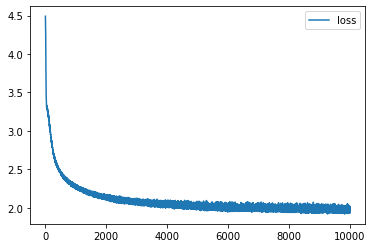

In [37]:
torch.save(model.state_dict(), "s.pth")

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [27]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    char_rnn.eval()
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else: 
        x_sequence = [token_to_idx['<sos>']]
    predicted = seed_phrase
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
#     print(x_sequence.shape)        
    
    #feed the seed phrase, if any
    # Use priming string to "build up" hidden state
    hidden = char_rnn.init_hidden().to(device)
    hidden = (hidden, hidden)
    for p in range(len(x_sequence) - 1):
#         _, hidden = char_rnn(x_sequence[:, p], hidden)
        _, hidden = char_rnn(x_sequence[:, p], *hidden)
#     print(x_sequence.shape)        
        
    inp = x_sequence[:, -1]
    
    for p in range(max_length):
#         print("input", inp.shape)        
#         output, hidden = char_rnn(inp, hidden)
        output, hidden = char_rnn(inp, *hidden)
#         print(output.shape)
        
#         print(hidden.shape)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
#         print(output_dist.shape)
        
        top_i = torch.multinomial(output_dist, 1)[0]
#         print(top_i)
        # Add predicted character to string and use as next input
        predicted_char = idx_to_token[top_i.item()]
        predicted += predicted_char
        inp = torch.tensor([token_to_idx[predicted_char]], dtype=torch.long).to(device)
        x_sequence += inp.unsqueeze(0)
#         print("last, inp ", inp)
    # your code here
#          print(predicted)
    return predicted
    return ''.join([idx_to_token[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [30]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

 мой дядя самых честных правиласё, бри номихагосто,
сера.

жен вь нигаконамей, рту еридьетв нн бе друк ладо след дувз вевезупрет.
стветретронь сваной даре те в н вый ди ве мескос; ней,



поныйнакамньстерускою з ст д тым м,
сльсчтом


е;
чтикатом толых га ескогре, нахонай коловожи табу ста би,

прахо ниждужи се ви сльнелалолаль,
ви поми гда новдвав к ненелемы,
нечеры
збил скаль, все енидресть емокри, чту в пра ни нидваколитновакив лждори днери нило побетеска в плее власто,
гохая бляланолом, бе вя гоене


ть,



ны дужене
тр,


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [18]:
seed_phrase = ' мой дядя самых честных правил'

In [34]:
# generated_phrases = # your code here

# For example:

generated_phrases = [
    generate_sample(
        model,
        ' мой дядя самых честных правил',
        max_length=470,
        temperature=.8
    ).replace('<sos>', '')
    for _ in range(10)
]

In [35]:
for phrase in generated_phrases:
    print(len(phrase))

500
500
500
500
500
500
500
500
500
500


In [36]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'
    

submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!